In [6]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [7]:
import torch
import matplotlib.pyplot as plt

### Callbacks

In [8]:
import ipywidgets as widgets

In [9]:
def f(o): print('hi')

In [12]:
w=widgets.Button(description='Click me')

In [14]:
w

Button(description='Click me', style=ButtonStyle())

In [15]:
w.on_click(f)

#### own callback

In [19]:
from time import sleep

In [20]:
def slow_calculation():
    res = 0
    for i in range(5):
        res+=i*i
        sleep(1)
    return res

In [21]:
slow_calculation()

30

In [22]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res+=i*i
        sleep(1)
        if cb: cb(i)
    return res

In [24]:
def show_progress(epoch):
    print(f"we have finished epoch {epoch}")

In [25]:
slow_calculation(show_progress)

we have finished epoch 0
we have finished epoch 1
we have finished epoch 2
we have finished epoch 3
we have finished epoch 4


30

In [26]:
slow_calculation(lambda o: print(f"epoch {o}"))

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


30

In [28]:
def show_progress(exclamation,epoch):
    print(f"{exclamation}! we have finished epoch {epoch}")

In [30]:
slow_calculation(lambda o: show_progress("OK I guess",o))

OK I guess! we have finished epoch 0
OK I guess! we have finished epoch 1
OK I guess! we have finished epoch 2
OK I guess! we have finished epoch 3
OK I guess! we have finished epoch 4


30

In [31]:
def make_show_progress(exclamation):
    def _inner(epoch): print(f"{exclamation}! We've finished epoch {epoch}")
    return _inner

In [33]:
slow_calculation(make_show_progress("Nice"))

Nice! We've finished epoch 0
Nice! We've finished epoch 1
Nice! We've finished epoch 2
Nice! We've finished epoch 3
Nice! We've finished epoch 4


30

In [34]:
f2 = make_show_progress("Great")

In [35]:
slow_calculation(f2)

Great! We've finished epoch 0
Great! We've finished epoch 1
Great! We've finished epoch 2
Great! We've finished epoch 3
Great! We've finished epoch 4


30

In [36]:
from functools import partial

In [37]:
slow_calculation(partial(show_progress,"Ok"))

Ok! we have finished epoch 0
Ok! we have finished epoch 1
Ok! we have finished epoch 2
Ok! we have finished epoch 3
Ok! we have finished epoch 4


30

In [38]:
f2 = partial(show_progress,"Ok")

In [39]:
f2?

#### callbacks as callable classes

In [40]:
class ProgressShowingCallback:
    def __init__(self,exclamation="Awesome"): self.exclamation=exclamation
    def __call__(self,epoch): print(f"{self.exclamation}! We've finished epoch {epoch}!")

In [41]:
cb = ProgressShowingCallback("Super")

In [42]:
slow_calculation(cb)

Super! We've finished epoch 0!
Super! We've finished epoch 1!
Super! We've finished epoch 2!
Super! We've finished epoch 3!
Super! We've finished epoch 4!


30

In [43]:
cb(2)

Super! We've finished epoch 2!


#### multiple callback funcs with args kwargs

In [44]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb: cb.before_calc(i)
        res+=i*i
        sleep(1)
        if cb: cb.after_calc(i,val=res)
    return res

In [45]:
class PrintStepCallback:
    def __init__(self): pass
    def before_calc(self,*args,**kwargs): print(f"About to start")
    def after_calc(self,*args,**kwargs): print(f"Done step")

In [49]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In [51]:
class PrintStatusCallback:
    def __init__(self): pass
    def before_calc(self,epoch,**kwargs): print(f"About to start {epoch}")
    def after_calc(self,epoch,val,**kwargs): print(f"After epoch: {epoch}: {val}")

In [52]:
slow_calculation(PrintStatusCallback())

About to start 0
After epoch: 0: 0
About to start 1
After epoch: 1: 1
About to start 2
After epoch: 2: 5
About to start 3
After epoch: 3: 14
About to start 4
After epoch: 4: 30


30

#### modifying behavior

In [53]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb,'before_calc'): cb.before_calc(i)
        res+=i*i
        sleep(1)
        if cb and hasattr(cb,'after_calc'): 
            if cb.after_calc(i,val=res):
                print("stopping early")
                break
    return res

In [54]:
class PrintAfterCallback():
    def after_calc(self,epoch,val):
        print(f"After {epoch}: {val}")
        if val>10:return True

In [55]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
stopping early


14

In [56]:
class SlowCalculator:
    def __init__(self,cb=None): self.cb,self.res=cb,0
    
    def callback(self, cb_name, *args):
        if not self.cb: return 
        cb = getattr(self.cb,cb_name,None)
        if cb: return cb(self,*args)
        
    def calc(self):
        for i in range(5):
            self.callback('before_calc',i)
            self.res+=i*i
            sleep(1)
            if self.callback('after_calc',i):
                print("stopping early")
                break

In [57]:
class ModifyingCallback:
    def after_calc(self,calc,epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res>10: return True
        if calc.res<3: calc.res = calc.res*2

In [59]:
calc = SlowCalculator(ModifyingCallback())

In [60]:
calc.calc()
calc.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
stopping early


15

class SlowCalculator:
    def __init__(self,cb=None): self.cb,self.res=cb,0
    
    def __call__(self, cb_name, *args):
        if not self.cb: return 
        cb = getattr(self.cb,cb_name,None)
        if cb: return cb(self,*args)
        
    def calc(self):
        for i in range(5):
            self('before_calc',i)
            self.res+=i*i
            sleep(1)
            if self('after_calc',i):
                print("stopping early")
                break

### Dunder

In [62]:
class SloppyAdder:
    def __init__(self,o): self.o=o
    def __add__(self,b): return SloppyAdder(self.o+b.o+0.01)
    def __repr__(self): return str(self.o)

In [67]:
a = SloppyAdder(1)
b = SloppyAdder(2)
c = a+b
c,type(c)

(3.01, __main__.SloppyAdder)

### Variance

In [69]:
t=torch.tensor([1.,2.,4.,18.])

In [71]:
m=t.mean();m

tensor(6.2500)

In [73]:
(t-m).mean()

tensor(0.)

In [74]:
(t-m).pow(2).mean()

tensor(47.1875)

In [77]:
(t-m).abs().mean()

tensor(5.8750)

In [75]:
(t-m).pow(2).mean().sqrt()

tensor(6.8693)

In [78]:
(t-m).pow(2).mean(), (t*t).mean()-(m*m)

(tensor(47.1875), tensor(47.1875))

#### covariance and correlation

In [79]:
t

tensor([ 1.,  2.,  4., 18.])

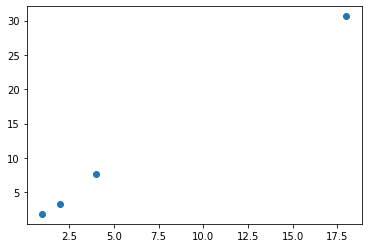

In [81]:
#u will be twice t pus randomness
u=t*2
u*=torch.randn_like(t)/10+0.95
plt.scatter(t,u)

In [82]:
prod = (t-t.mean())*(u-u.mean());prod

tensor([ 47.3699,  31.9641,   7.1533, 231.7455])

In [83]:
prod.mean()

tensor(79.5582)

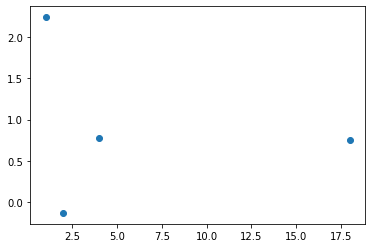

In [84]:
v = torch.randn_like(t)
plt.scatter(t,v)

In [86]:
((t-t.mean())*(v-v.mean())).mean()

tensor(-1.0390)

In [87]:
cov = (t*v).mean()-t.mean()*v.mean()

In [88]:
cov

tensor(-1.0390)

In [89]:
cov/(t.std()*v.std())

tensor(-0.1338)

### Softmax

In [91]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()